In [93]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [94]:
def plot_images(image_left, image_right):
    plt.subplot(1, 2, 1)
    plt.title("hori line")
    plt.imshow(image_left, "gray")
    # plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("vert line")
    plt.imshow(image_right, cmap="gray")
    # plt.colorbar()

def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_derivatives(deriv):
    plt.subplot(1, 2, 1)
    plt.title("LSF for all rows")
    for i in range(deriv.shape[0]):
        plt.plot(deriv[i, :])
    
    plt.subplot(1, 2, 2)
    plt.title("LSF for first row")
    plt.plot(deriv[0,:])      

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image, centroid, fit):
    plt.title("LSF and fittings")
    plt.imshow(image)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid

    plt.plot(np.polyval(fit, x), x, "y")

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45
    # px=2.75

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [95]:
filename = "red_hori_+22deg_2222_rot.png"
filename = "_s2/_r_0deg_0mm_offaperture_1333.png"
filename = "xcube_data/0803/s1_red_140ma_508us_22.503mm.png"

coarse_scan_files = [
    {
        "title": "22.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.503mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.803mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    # {
    #     "title": "22.903mm",
    #     "filename": "xcube_data/0803/s1_red_140ma_508us_22.903mm.png",
    #     "roi_h_pos": (460, 1040),
    #     "roi_v_pos": (1195, 670)
    # },
    {
        "title": "23.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.003mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.103mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.203mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    # {
    #     "title": "23.303mm",
    #     "filename": "xcube_data/0803/s1_red_140ma_508us_23.303mm.png",
    #     "roi_h_pos": (460, 1035),
    #     "roi_v_pos": (1190, 670)
    # },
    {
        "title": "23.403mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.403mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1190, 670)
    },
    {
        "title": "23.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.503mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "23.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.803mm.png",
        "roi_h_pos": (460, 1045),
        "roi_v_pos": (1205, 670)
    },
    {
        "title": "23.903mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.903mm.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.003mm.png",
        "roi_h_pos": (460, 1060),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.103mm.png",
        "roi_h_pos": (460, 1070),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.203mm.png",
        "roi_h_pos": (460, 1080),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.303mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.303mm.png",
        "roi_h_pos": (460, 1090),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.403mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.403mm.png",
        "roi_h_pos": (460, 1100),
        "roi_v_pos": (1210, 670)
    },
]

In [96]:
fine_scan_files = [
    {
        "title": "22.800mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.800.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.825mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.825.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.850mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.850.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.875mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.875.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.900mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.900.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.925mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.925.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.950mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.950.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.975mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.975.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.000mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.000.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.025mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.025.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.050mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.050.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.075mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.075.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.100mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.100.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.125mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.125.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.150mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.150.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.175mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.175.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.200mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.200.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.225mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.225.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.250mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.250.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.275mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.275.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.300mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.300.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.325mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.325.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.350mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.350.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.375mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.375.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.400mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.400.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
]

In [97]:
def thru_focus(index, freq, files):
    # step 0: load image
    file_item = files[index]
    image = step0_load_image(file_item["filename"])
    title = file_item["title"]
    
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + 200, file_item["roi_h_pos"][1] + 160), 90) #90
    roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + 160, file_item["roi_v_pos"][1] + 200), 0)
    # plot_images(roi_image_h, roi_image_v)
    
    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    
    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    # plot_derivatives(deriv_h)
    # plot_derivatives(deriv_v)
    
    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    # plt.plot(1, 2, 1)
    # plot_centroid(deriv_h, centroid_h, fit_h)
    # plt.plot(1, 2, 2)
    # plot_centroid(deriv_v, centroid_v, fit_v)
    
    # step 5: compute polynomial fit to central locations
    
    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)
    
    # step 6: super-sample
    
    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    # plt.plot(esf_h)
    # plt.plot(esf_v)
    
     # step 7: compute 1D derivative (LSF)
    
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    # plt.plot(lsf1_h)
    # plt.plot(lsf1_v)
    
    # step 8: apply window to LSF
    
    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200) 
    
    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    # plot_mtf(freq_data_h, mtf_data_h, "h", "-")
    # plot_mtf(freq_data_v, mtf_data_v, "v", "--")
    
    freq, mtf_h = step10_get_mtf_interp(mtf_data_h, freq_data_h, freq)
    freq, mtf_v = step10_get_mtf_interp(mtf_data_v, freq_data_v, freq)

    result = {
        "title": title,
        "freq": freq,
        "mtf_h": float(mtf_h),
        "mtf_v": float(mtf_v),
        "roi_image_h": roi_image_h,
        "roi_image_v": roi_image_v,
        "lsf_h": lsf_h,
        "lsf_v": lsf_v,
        "freq_data": freq_data_h,
        "mtf_data_h": mtf_data_h,
        "mtf_data_v": mtf_data_v
    }
    return result



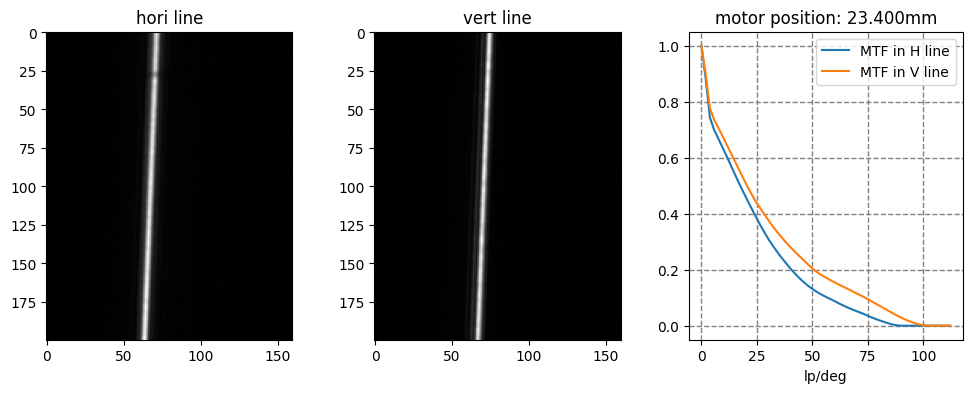

In [98]:

t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25
idx = 24

res = thru_focus(idx, freqency, fine_scan_files)
# print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
# t_focus_d.append(float(res["title"][0:-2]))
# t_focus_h.append(res["mtf_h"])
# t_focus_v.append(res["mtf_v"])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(res["roi_image_h"], "gray")
axes[0].set_title("hori line")

axes[1].imshow(res["roi_image_v"], "gray")
axes[1].set_title("vert line")

axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_h"][0:freq_numbers], label='MTF in H line', linestyle='-')
axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_v"][0:freq_numbers], label='MTF in V line', linestyle='-')
axes[2].set_title(f"motor position: {res['title']}")
axes[2].set_xlabel("lp/deg")
axes[2].grid(color='gray', linestyle='--', linewidth=1)
axes[2].legend()

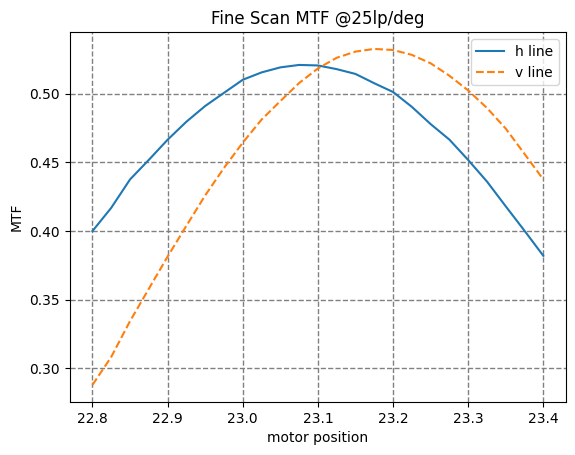

In [99]:

t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25
idx = 18

for idx in range(len(fine_scan_files)):
    res = thru_focus(idx, freqency, fine_scan_files)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    t_focus_d.append(float(res["title"][0:-2]))
    t_focus_h.append(res["mtf_h"])
    t_focus_v.append(res["mtf_v"])

# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d, t_focus_h, label="h line", linestyle="-")
plt.plot(t_focus_d, t_focus_v, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Fine Scan MTF @25lp/deg")
plt.legend()

In [100]:
print(t_focus_h)
print(t_focus_v)

[0.39998501210042897, 0.4169238086299687, 0.43757801730688084, 0.4518321636889023, 0.4664903715640198, 0.47962163243730044, 0.4910646520556956, 0.5006377131003437, 0.510165895325033, 0.5155228901421341, 0.5191955141818093, 0.520974385952881, 0.5205985593071845, 0.5179135569121674, 0.5144169654912298, 0.5076355226303023, 0.5012604667454506, 0.49045045463031006, 0.477899751429295, 0.4665736004967892, 0.4517249087187082, 0.43603922975966136, 0.41798052361207527, 0.4001649208027284, 0.38195717829277037]
[0.2879444755327078, 0.30833392479025046, 0.3344201460634243, 0.35793219778630386, 0.3813825785267576, 0.4038461059937518, 0.4259457103084898, 0.44596809871794496, 0.46437217829057104, 0.48113846114946845, 0.4946331141118136, 0.5077807272220747, 0.518419815092708, 0.5261849910067969, 0.5306754922227505, 0.5326337166659695, 0.531852124280522, 0.5283080440052182, 0.5221671005533419, 0.5130998192801445, 0.5023927651515926, 0.48960368783052305, 0.47458590231925263, 0.456119776048727, 0.43755295

In [101]:
print(t_focus_h[11])
print(t_focus_v[15])

0.520974385952881
0.5326337166659695


In [102]:
vid_h=30.245
vid_v=38.384

In [103]:
motor_diff = 0.1